### 분석목표
Glassdoor 채용공고 데이터를 바탕으로 KMeans 클러스터링을 적용하여 유사한 직무군을 군집화하고,

구직자의 입력값과 유사한 공고를 추천하는 시스템을 구현.



직무, 직급, 위치, 선호 산업 등 구직자 정보 입력시,
 가장 가까운 기업리스트 추천 및 기업 정보를 제공 -

 구직자관점에서의 적합한 회사 추천, 급여 기대 수준의 현실화


### 과정
1. Feature Selection 및 추가 전처리

2. 클러스터링(k-means) 및 시각화

3. 구직자 조건과 가장 가까운 클러스터 탐색 (유클리드 거리 기반)

4. 추천 결과 제공


### Feature Selection

1) 클러스터링을 수행하므로 수치형 데이터를 활용

2) 실험적으로, 순서형 데이터와 범주형 데이터를 일부 활용한 시나리오도 고려

순서형데이터는 수치형과 동일하게 스케일링을 적용하고, 범주형 데이터는 일부 주요 피쳐들을 원핫인코딩 하여 적용

위 기준을 바탕으로, 중요도를 고려하여 다음을 사용하기로 결정
- 수치형: 'min_salary', 'max_salary', 'avg_salary', 'Rating', 'Company_age', 'Revenue'
- 순서형: 'Position_Encoded', 'Size_cleaned'
- 범주형: 'Job Title', 'Location_state_binned', 'Sector'
    

### 전처리


In [1]:
import pandas as pd

# ────────────────────────────────────────
# Step 1. 데이터 로드
# ────────────────────────────────────────
df = pd.read_csv("glassdoor_cleaned_final.csv")

# ────────────────────────────────────────
# Step 2. salary 그룹 기반 중앙값 대체
# ────────────────────────────────────────
df['avg_salary'] = df.groupby(
    ['Job Title', 'Position_Encoded', 'Sector']
)['avg_salary'].transform(lambda x: x.fillna(x.median()))

df['min_salary'] = df.groupby(
    ['Job Title', 'Position_Encoded', 'Sector']
)['min_salary'].transform(lambda x: x.fillna(x.median()))

df['max_salary'] = df.groupby(
    ['Job Title', 'Position_Encoded', 'Sector']
)['max_salary'].transform(lambda x: x.fillna(x.median()))

# ────────────────────────────────────────
# Step 3. Size_cleaned 오디널 인코딩
# ────────────────────────────────────────
size_map = {
    'Small': 1,
    'Medium': 2,
    'Large': 3,
    'Very Large': 4
}
df['Size_cleaned'] = df['Size_cleaned'].map(size_map)

# ────────────────────────────────────────
# Step 4. 결측치가 있는 행 제거
# ────────────────────────────────────────
print("피처별 결측치 개수:")
print(df.isna().sum().sort_values(ascending=False))

before_drop = df.shape[0]
df_cleaned = df.dropna()
after_drop = df_cleaned.shape[0]
num_dropped = before_drop - after_drop

# ────────────────────────────────────────
# Step 5. 중복 행 제거
# ────────────────────────────────────────
before_dup = df_cleaned.shape[0]
df_cleaned = df_cleaned.drop_duplicates()
after_dup = df_cleaned.shape[0]
num_dropped_dup = before_dup - after_dup

# ────────────────────────────────────────
# Step 6. 결과 저장
# ────────────────────────────────────────
df_cleaned.to_csv("glassdoor_cleaned_for_clustering.csv", index=False)

# ────────────────────────────────────────
# Step 7. 확인
# ────────────────────────────────────────
print(f"결측치 제거 전 행 수: {before_drop}")
print(f"결측치 제거 후 행 수: {after_drop} (제거된 결측 행 수: {num_dropped})")
print(f"중복 제거 후 최종 행 수: {after_dup} (제거된 중복 행 수: {num_dropped_dup})")
print("저장 완료: glassdoor_cleaned_for_clustering.csv")

피처별 결측치 개수:
Company_age                  112
Size_cleaned                  87
min_salary                    49
max_salary                    49
avg_salary                    49
Position_Encoded              38
Company Name                   0
Job Title                      0
Location_state_binned          0
Rating                         0
works_at_headquarters          0
Headquarters_state_binned      0
Ownership_Grouped              0
Industry                       0
Sector                         0
Revenue                        0
dtype: int64
결측치 제거 전 행 수: 956
결측치 제거 후 행 수: 764 (제거된 결측 행 수: 192)
중복 제거 후 최종 행 수: 488 (제거된 중복 행 수: 276)
저장 완료: glassdoor_cleaned_for_clustering.csv


### 클러스터링 수행


▶ 시나리오: Numeric Only


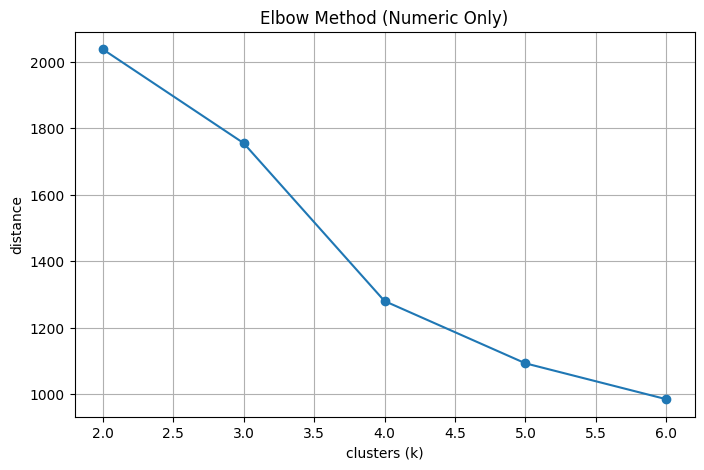

Silhouette Score (Numeric Only): 0.266
Davies-Bouldin Index (Numeric Only): 1.189


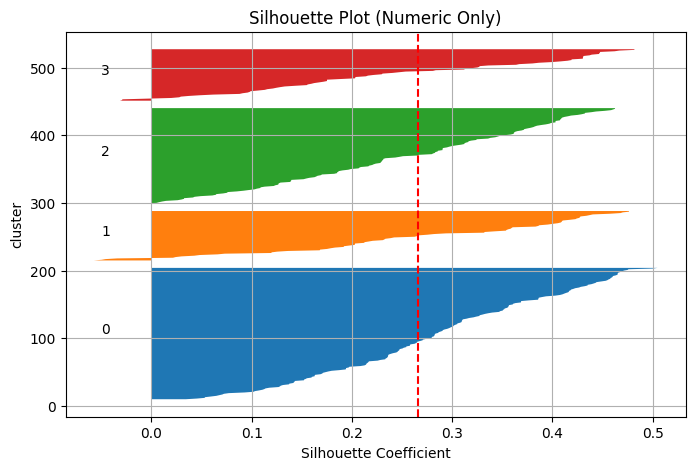

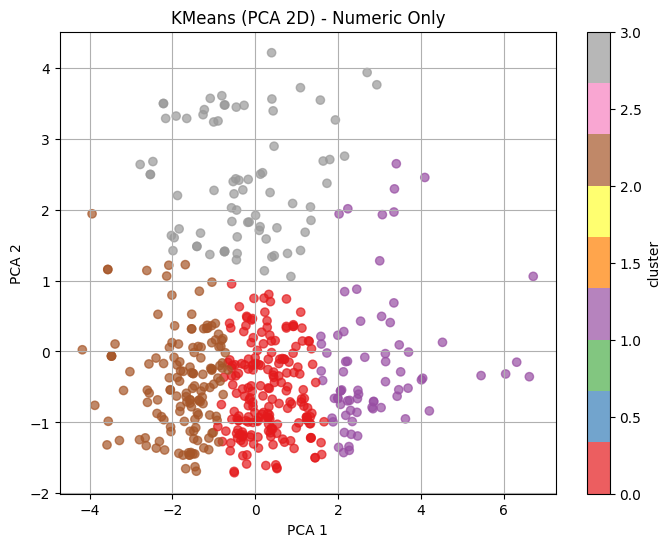


[클러스터별 통계 요약 (평균)]
         avg_salary  Rating  Company_age      Revenue
cluster                                              
0             102.9     3.9         31.2  606618641.0
1             157.1     4.0         27.7 1509931959.5
2              61.7     3.6         41.5  971932535.2
3              97.5     3.6        115.2 8662853896.1

가장 가까운 클러스터: cluster#0
해당 클러스터에서 가장 가까운 공고 Top 10:
                Company Name         Job Title  Position_Encoded  \
253                  ManTech  Data Engineering               2.0   
143                     PNNL      Data Science               4.0   
434          Mentor Graphics      Data Science               2.0   
108                 Autodesk  Data Engineering               2.0   
140             PatientPoint      Data Science               6.0   
263                  SciPlay  Data Engineering               2.0   
153  Legal & General America      Data Science               2.0   
257              CyberCoders      Data Science              

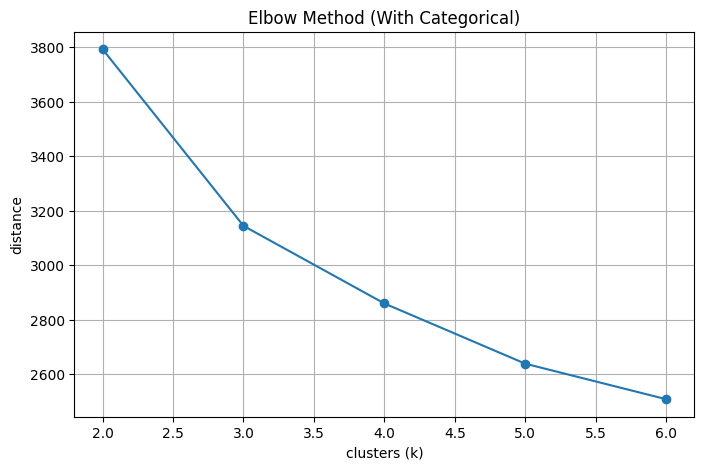

Silhouette Score (With Categorical): 0.210
Davies-Bouldin Index (With Categorical): 1.551


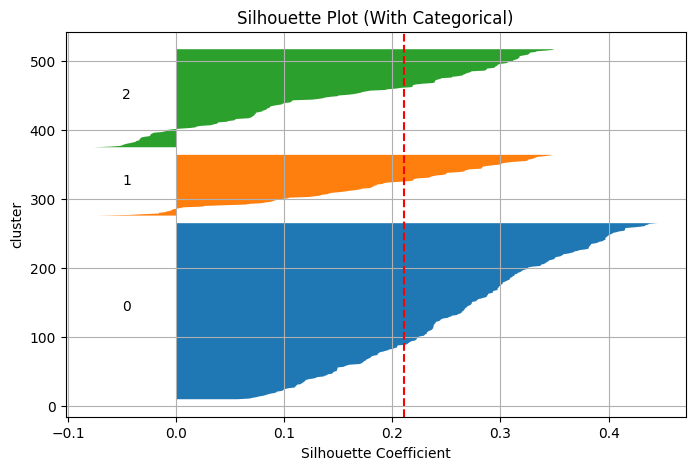

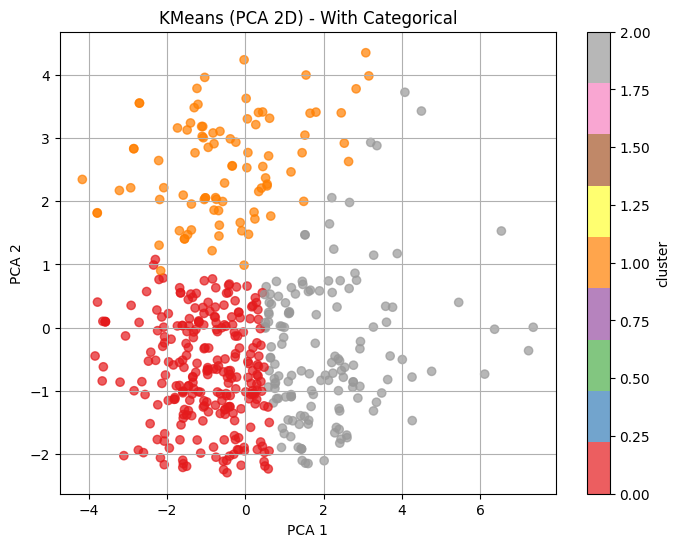


[클러스터별 통계 요약 (평균)]
         avg_salary  Rating  Company_age      Revenue
cluster                                              
0              77.6     3.8         37.4  592357988.3
1              95.2     3.6        107.0 8400558988.8
2             137.1     3.9         26.5  949555069.9

가장 가까운 클러스터: cluster#0
해당 클러스터에서 가장 가까운 공고 Top 10:
          Company Name         Job Title  Position_Encoded  \
34                Esri      Data Science               2.0   
434    Mentor Graphics      Data Science               2.0   
31    Juniper Networks      Data Science               2.0   
386          Brillient      Data Science               2.0   
33    Clarity Insights     Data Analysis               2.0   
332               Esri      Data Science               2.0   
38          Sauce Labs     Data Analysis               2.0   
81               goTRG      Data Science               2.0   
108           Autodesk  Data Engineering               2.0   
473  SoftBank Robotics      Data Scien

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

# 데이터 불러오기
df = pd.read_csv("glassdoor_cleaned_for_clustering.csv")

# 피처 그룹 정의
numeric_cols = ['min_salary', 'max_salary', 'avg_salary', 'Rating', 'Company_age', 'Revenue']
ordered_cols = ['Position_Encoded', 'Size_cleaned']
categorical_cols = ['Job Title', 'Location_state_binned', 'Sector']

# 시나리오 정의
scenarios = {
    'Numeric Only': numeric_cols,
    'With Categorical': numeric_cols + ordered_cols + categorical_cols
}

# 클러스터링 및 추천 파이프라인
def run_cluster_pipeline(df, scenario_features, scenario_name):
    print(f"\n▶ 시나리오: {scenario_name}")

    # 시나리오에 맞는 피처 분리
    cat_cols = [col for col in categorical_cols if col in scenario_features]
    ord_cols = [col for col in ordered_cols if col in scenario_features]
    num_cols = [col for col in numeric_cols if col in scenario_features]

    # 피처 필터링
    df_filtered = df[num_cols + ord_cols + cat_cols].copy()

    # 원-핫 인코딩
    df_encoded_cat = pd.get_dummies(df_filtered[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=df_filtered.index)

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_filtered[num_cols + ord_cols])

    # 최종 데이터 구성
    X_final = np.hstack([X_scaled, df_encoded_cat.values]) if not df_encoded_cat.empty else X_scaled

    # Elbow Method
    inertias = []
    for k in range(2, 7):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_final)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 7), inertias, marker='o')
    plt.title(f"Elbow Method ({scenario_name})")
    plt.xlabel("clusters (k)")
    plt.ylabel("distance")
    plt.grid(True)
    plt.show()

    # KMeans 클러스터링 (k=3)
    # 시나리오별 k값 설정
    if scenario_name == 'Numeric Only':
        k_value = 4
    elif scenario_name == 'With Categorical':
        k_value = 3

    kmeans = KMeans(n_clusters=k_value, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_final)

    # 클러스터 품질 평가 지표
    sil_score = silhouette_score(X_final, df['cluster']) # silhouette score
    db_index = davies_bouldin_score(X_final, df['cluster']) # davies-bouldin index (별도 서술)

    print(f"Silhouette Score ({scenario_name}): {sil_score:.3f}")
    print(f"Davies-Bouldin Index ({scenario_name}): {db_index:.3f}")

    sil_values = silhouette_samples(X_final, df['cluster'])
    y_lower = 10
    plt.figure(figsize=(8, 5))
    for i in range(k_value):
        ith_cluster_sil = sil_values[df['cluster'] == i]
        ith_cluster_sil.sort()
        size_cluster_i = ith_cluster_sil.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.axvline(x=sil_score, color="red", linestyle="--")
    plt.title(f"Silhouette Plot ({scenario_name})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("cluster")
    plt.grid(True)
    plt.show()

    # PCA 2차원 시각화
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_final)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='Set1', alpha=0.7)
    plt.title(f"KMeans (PCA 2D) - {scenario_name}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(scatter, label='cluster')
    plt.grid(True)
    plt.show()

    # 사용자 입력 (시나리오별)
    if scenario_name == "Numeric Only":
        input_data = {
            'min_salary': 80, #단위: 1000달러
            'max_salary': 120,
            'avg_salary': 100,
            'Rating': 4.0,

            #dummy 변수는 평균값으로 대체
            'Company_age': df['Company_age'].mean(),
            'Revenue': df['Revenue'].mean()
        }
    else:
        input_data = {
            'Job Title': 'Data Science',
            'Location_state_binned': 'ca',
            'Sector': 'Technology',
            'Position_Encoded': 2.0,

            #dummy 변수는 평균값으로 대체
            'Size_cleaned': df['Size_cleaned'].mean(),
            'min_salary': df['min_salary'].mean(),
            'max_salary': df['max_salary'].mean(),
            'avg_salary': df['avg_salary'].mean(),
            'Rating': df['Rating'].mean(),
            'Company_age': df['Company_age'].mean(),
            'Revenue': df['Revenue'].mean()
        }

    # 클러스터 통계 요약
    pd.set_option('display.float_format', '{:.1f}'.format)

    cluster_summary = df.groupby('cluster')[
        ['avg_salary', 'Rating', 'Company_age', 'Revenue']
    ].mean().round(1)

    print("\n[클러스터별 통계 요약 (평균)]")
    print(cluster_summary)


    # 시나리오별 입력 필터링
    input_data = {k: input_data[k] for k in (num_cols + ord_cols + cat_cols)}
    input_df = pd.DataFrame([input_data])

    input_scaled = scaler.transform(input_df[num_cols + ord_cols])
    input_encoded = pd.get_dummies(input_df[cat_cols]) if cat_cols else pd.DataFrame(index=[0])
    input_encoded = input_encoded.reindex(columns=df_encoded_cat.columns, fill_value=0)
    input_final = np.hstack([input_scaled, input_encoded.values]) if not input_encoded.empty else input_scaled

    # 가까운 클러스터 및 거리 계산
    distances = np.sum(np.power(kmeans.cluster_centers_ - input_final, 2), axis=1) ** 0.5
    nearest_cluster = np.argmin(distances)

    dist_matrix = euclidean_distances(X_final, input_final.reshape(1, -1))
    df['distance_to_user'] = dist_matrix.flatten()

    top_matches = df.sort_values(by='distance_to_user')[
        ['Company Name', 'Job Title', 'Position_Encoded', 'Location_state_binned', 'Sector', 'avg_salary', 'Company_age', 'Rating']
    ].head(10)

    print(f"\n가장 가까운 클러스터: cluster#{nearest_cluster}")
    print("해당 클러스터에서 가장 가까운 공고 Top 10:")
    print(top_matches.round(1))


# 각 시나리오 실행
for name, feature_list in scenarios.items():
    run_cluster_pipeline(df.copy(), feature_list, name)


### 배운점, 한계점

- 모델링을 적용함에 있어서 feature selection의 어려움 - 다양한 피쳐들을 사용할 수 있도록 시나리오를 나누어 해결

- 원핫인코딩 된 범주형 데이터에 유클리드 거리를 계산하면, 타겟과의 일치 여부는 확인 할 수 있지만, 항목 간 유사성을 반영할 수 없고, 차원의 저주 문제가 따라온다
  - 실제로 더 낮은 실루엣계수를 보임, 거리계산 방식에서 범주형 피쳐의 한계를 재확인, 추후 수치형과 범주형을 동시에 처리할 수 있는 K-prototype 클러스터링을 적용해 볼 계획

- PCA를 통한 시각화로 결과를 정성평가 했지만, 정량적인 Evaluation의 부재 - elbow method를 통해 최적 k를 탐색하고, shillouete score를 활용해 퀄리티를 측정, 추가로 davies bouldin score를 탐구하고 적용
  
- 사용자 입력용 더미값으로서 0을 넣으면, 편향이 발생함 - '입력없음'의 개념을 평균값으로 처리함